In [94]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import pandas as pd

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [91]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()
    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [95]:
def featureSelect(path, k, nlargest):
    data = pd.read_csv(path)
    x = data[data.columns[1:94]]
    y = data[data.columns[94]]
    X = (x - x.mean()) / x.std()
    bestFeatures = SelectKBest(score_func = f_regression, k = k)
    fit = bestFeatures.fit(X, y)
    scores = pd.DataFrame(fit.scores_)
    columns = pd.DataFrame(x.columns)
    featureScores = pd.concat([columns, scores], axis = 1)
    featureScores.columns = ['Specs', 'Score']
    return list(featureScores.nlargest(nlargest, 'Score').index)

In [106]:
class COVID19Dataset(Dataset):
    def __init__(self, path, feats = [], mode = 'train', target_only = False):
        self.mode = mode
        
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:,1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            #feats = list(range(40)) + [57, 75]
            #feats = featureSelect(path, 5, 15)
            pass
        
        if self.mode == 'test':
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            target = data[:, -1]
            data = data[:, feats]
            
            if self.mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            else:
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])
        
        self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim = 0, keepdim = True)) / self.data[:, 40:].std(dim = 0, keepdim = True)
        
        self.dim = self.data.shape[1]
        
        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))
    
    def __getitem__(self, index):
        if self.mode in ['train', 'dev']:
            return self.data[index], self.target[index]
        else:
            return self.data[index]
    
    def __len__(self):
        return len(self.data)

In [107]:
def prep_dataloader(path, feats, mode, batch_size, n_jobs = 0, target_only = False):
    dataset = COVID19Dataset(path, feats, mode, target_only)
    dataloader = DataLoader(dataset, batch_size, shuffle = (mode == 'train'), num_workers = n_jobs, drop_last = False, pin_memory=True)
    return dataloader

In [104]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32), #使用BN，加速模型训练
            nn.Dropout(p = 0.2), #使用Dropout，减小过拟合，注意不能在BN之前 
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )
        
        self.criterion = nn.MSELoss(reduction = 'mean')
    
    def forward(self, x):
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        reg_loss = 0
        for param in self.parameters():
            reg_loss += torch.sum(param ** 2)
        return self.criterion(pred, target) + 0.00075 * reg_loss

In [113]:
def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    for x, y in dv_set:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            mse_loss = model.cal_loss(pred, y)
            total_loss += mse_loss.detach().cpu().item() * len(x)
    total_loss = total_loss / len(dv_set.dataset)
    
    return total_loss

In [114]:
def test(tt_set, model, device):
    model.eval()
    preds = []
    for x in tt_set:
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim = 0).numpy()
    return preds

In [115]:
def train(tr_set, dv_set, model, config, device):
    
    n_epochs = config['n_epochs']
    
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])
    
    loss_record = {'train':[], 'dev':[]}
    early_stop_cnt = 0
    epoch = 0
    min_mse = 1000
    
    while epoch < n_epochs:
        model.train()
        for x, y in tr_set:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            mse_loss = model.cal_loss(pred, y)
            mse_loss.backward()
            optimizer.step()
            loss_record['train'].append(mse_loss.detach().cpu().item())

        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            min_mse = dev_mse

            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                    .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])

            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        loss_record['dev'].append(dev_mse)
        epoch += 1
        
        if early_stop_cnt > config['early_stop']:
            break
    
    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [116]:
tr_path = "covid.train.csv"
tt_path = "covid.test.csv"

device = get_device()
os.makedirs('models', exist_ok = True)
target_only = True

config = {
    'n_epochs': 10000,
    'batch_size': 200,
    'optimizer': 'Adam',
    'optim_hparas': {
        #'lr': 0.001,
        #'momentum': 0.9
    },
    'early_stop': 500,
    'save_path': 'models/model.pth'
}

feats = featureSelect(tr_path, 5, 14)

In [117]:
tr_set = prep_dataloader(tr_path, feats, 'train', config['batch_size'], target_only = target_only)
dv_set = prep_dataloader(tr_path, feats, 'dev', config['batch_size'], target_only = target_only)
tt_set = prep_dataloader(tt_path, feats, 'test', config['batch_size'], target_only = target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 14)


In [118]:
model = NeuralNet(tr_set.dataset.dim).to(device)

In [119]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 295.0916)
Saving model (epoch =    2, loss = 281.6156)
Saving model (epoch =    3, loss = 252.8888)
Saving model (epoch =    4, loss = 225.2979)
Saving model (epoch =   10, loss = 214.5549)
Saving model (epoch =   11, loss = 204.0517)
Saving model (epoch =   12, loss = 182.0695)
Saving model (epoch =   13, loss = 168.2814)
Saving model (epoch =   14, loss = 165.2566)
Saving model (epoch =   15, loss = 151.5687)
Saving model (epoch =   16, loss = 137.2500)
Saving model (epoch =   17, loss = 135.7879)
Saving model (epoch =   18, loss = 118.0500)
Saving model (epoch =   19, loss = 107.6240)
Saving model (epoch =   20, loss = 104.4849)
Saving model (epoch =   21, loss = 89.0941)
Saving model (epoch =   26, loss = 61.9218)
Saving model (epoch =   27, loss = 58.4295)
Saving model (epoch =   29, loss = 56.6932)
Saving model (epoch =   31, loss = 55.1465)
Saving model (epoch =   32, loss = 51.5185)
Saving model (epoch =   33, loss = 25.1684)
Saving model (epo

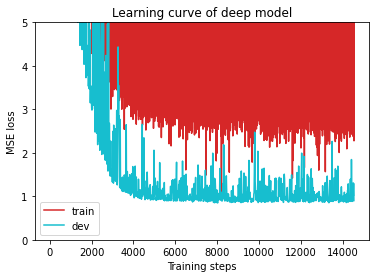

In [120]:
plot_learning_curve(model_loss_record, title='deep model')

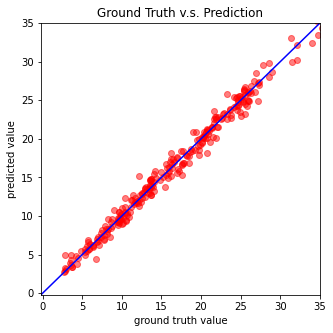

In [121]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location = 'cpu')
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)

In [122]:
def save_pred(preds, file):
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

In [123]:
preds = test(tt_set, model, device)
save_pred(preds, 'pred.csv')

Saving results to pred.csv
